# CNN implementation for DeepInsight images

## Data extraction and correction

The GSE70951 is composed of two series:

* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_1]*, with the code [GSE70905](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70905), which will be used as an external validation dataset
* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_2]*, with the code [GSE70947](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70947), which will be used for biomarker discovery
We will be using the second cohort for out study.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The data preprocessing and differential gene expression analysis was done in R using the `limma` package.

In [ ]:
!gdown https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo

Downloading...
From: https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo
To: /content/GSE70947.csv
100% 176M/176M [00:00<00:00, 211MB/s]


The `GSE70947` file has the gene expression information. The columns are divided in
* `index`, which have the GEO code for each patient
* `type`, which has the class at which each patient belongs (either healthy or adenocarcinoma)
* the rest of the columns, that have the name of the gen an its expression level

In [ ]:
gse = pd.read_csv('GSE70947.csv', index_col = 0)
X = gse.drop(["type"], axis = 1)
X.head()

,NM_144987,NM_013290,ENST00000322831,NM_001625,lincRNA:chr7:226042-232442_R,NM_032391,ENST00000238571,XR_108906,NM_005937,NM_152493,...,lincRNA:chr4:77860976-77869926_F,NM_152343,NM_001005327,NM_001039355,lincRNA:chr21:44456656-44468556_R,lincRNA:chr9:4869500-4896050_F,NM_016053,NM_001080425,ENST00000555638,ENST00000508993
GSM1823702,8.710837,7.752260,6.147044,11.330250,8.049364,4.786607,5.762913,4.673030,8.595702,10.700061,...,7.608246,6.452793,4.861030,10.751960,5.231761,6.099910,10.653872,8.983922,5.117210,5.231761
GSM1823703,9.386920,7.125349,7.033364,11.043588,8.546755,5.365691,5.564553,4.966745,8.505314,10.952910,...,7.933495,5.836469,3.858494,11.302093,4.003188,3.858494,10.751094,8.199526,4.085583,4.355808
GSM1823704,8.958187,7.993491,6.358601,11.548966,8.616110,5.402829,5.941259,5.093209,8.683907,10.574121,...,7.740297,6.668138,3.793648,10.581576,5.137291,6.605187,10.435313,8.493851,4.669778,5.225001
GSM1823705,9.034777,7.856471,6.260612,12.290221,7.724913,4.631357,6.745727,4.840550,8.573251,10.787665,...,6.704075,5.905563,4.458250,11.178242,5.123130,6.739206,11.113692,8.896214,4.358008,4.631357
GSM1823706,8.822363,7.593622,6.322608,12.204265,7.785088,4.295037,6.597042,4.366717,8.788972,10.818610,...,6.304331,5.672441,4.557420,12.016128,5.110453,6.496323,10.913592,9.536360,4.673507,4.557420


Extracting the target,

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = gse["type"].values

## DeepInsight image transformation

In [ ]:
!git clone https://github.com/alok-ai-lab/pyDeepInsight.git

Cloning into 'pyDeepInsight'...
remote: Enumerating objects: 419, done.
remote: Counting objects: 100% (416/416), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 419 (delta 188), reused 377 (delta 174), pack-reused 3
Receiving objects: 100% (419/419), 19.98 MiB | 13.07 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [ ]:
%cd /content/pyDeepInsight

/content/pyDeepInsight


Installing dependencies.

In [ ]:
!pip install -q umap-learn timm grad_cam torchcam torch==2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.5 MB/s eta 0:00:00


Importing necessary libraries for the image transformation and the implementation of the Squeezenet CNN.

In [ ]:
from pyDeepInsight import ImageTransformer, CAMFeatureSelector
from pyDeepInsight.utils import Norm2Scaler

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

First, we divide the data in the training and testing sets, and scale between 0 and 1.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=43,
                                                    stratify=y)


In [ ]:
# Standardization yields very low performance scores
# mms = MinMaxScaler()
# X_train_norm = mms.fit_transform(X_train)
# X_test_norm = mms.fit_transform(X_test)

In [ ]:
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


The classes are already encoded. If not, use `LabelEncoder()` or similar.

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

Now, we convert the tabular data into the DeepInsight image format.

In [ ]:
reducer = umap.UMAP(
    n_components=2,
    #min_dist=0.8,
    metric='cosine', # cosine
    n_jobs=-1
)

pixel_size = (225,225) # 227 x 227
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

/content/pyDeepInsight/pyDeepInsight/image_transformer.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


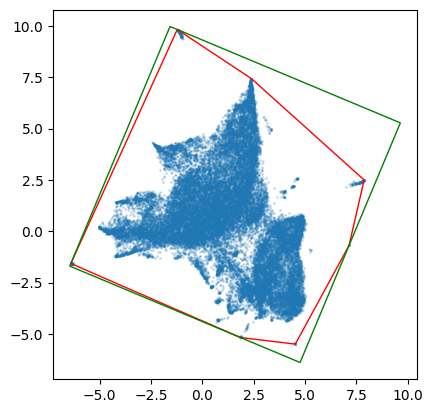

In [ ]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

Observing the data (training set).

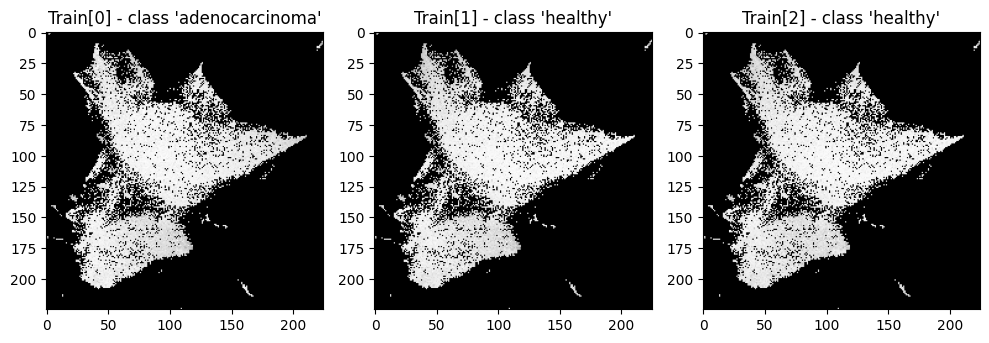

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

## CNN implementation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#timm.list_models(pretrained=True)

In [ ]:
# resnet26d gives the best performance without additional layers
net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

In [ ]:
#@title CNN training and testing


batch_size = 52 # 52
epoch_size = 26 # 26
lr = 1e-02 # 1e-02
m = 0.9 # 0.9

# Avoid normalizing tensor if you want to do the GradCAM
# if not, you need to re-scale the output
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=lr, #1e-02
    momentum=m, # 0.9
)

net.train()
for epoch in range(epoch_size): # 20
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

test_predicted = np.empty(0)
test_true = np.empty(0)

net.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())

# Performance
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
print(f"The test precision was {precision_score(test_predicted, test_true):.3f}")
print(f"The test recall was {recall_score(test_predicted, test_true):.3f}")
print(f"The test F1 score was {f1_score(test_predicted, test_true):.3f}")

The test accuracy was 0.828
The test precision was 0.966
The test recall was 0.757
The test F1 score was 0.848


In [ ]:
# Save the state_dict
# IMPORTANT: models needs to be reconstructed when loaded
#torch.save(net.state_dict(), 'deepinsight.pth')
#https://colab.research.google.com/github/agungsantoso/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%206%20-%20Saving%20and%20Loading%20Models.ipynb#scrollTo=thI8wHA2pCX-

## CAM-based Feature Selection

Create the `CAMFeatureSelector`, which needs as inputs the DeepInsight images and the trained CNN model.

In [ ]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    cam_method=cm_method
)

Then, we should compute the CAM for each image. For the flatten method, we will use

In [ ]:
# From https://github.com/alok-ai-lab/pyDeepInsight/blob/master/examples/cam_feature_selection.ipynb
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                            constrained_layout=True)
    for cat in np.unique(y):
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[cat].imshow(visualization)
        axs[cat].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[cat].text(225,225,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[cat].axis('off')
    return fig, axs

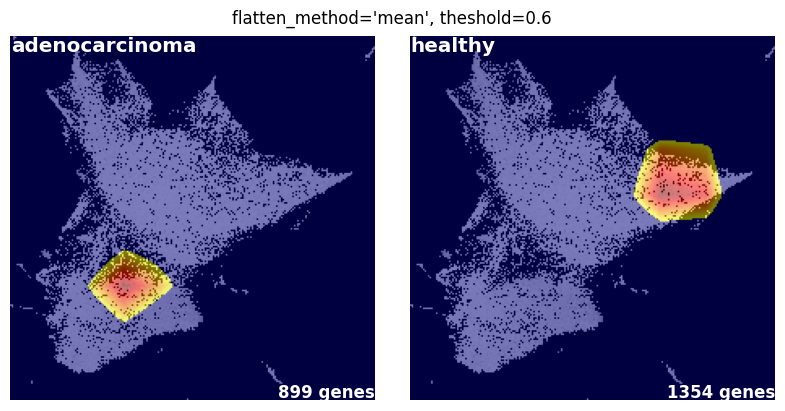

In [ ]:
fl_method = 'mean'
fs_threshold = 0.6

class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"flatten_method='{fl_method}', theshold={fs_threshold}")
plt.show()

In [ ]:
result = {}
for cat, idx in feat_idx.items():
    feature_names = X.columns[idx]
    result[le_mapping[cat]] = feature_names.to_list()